In [4]:
print("all Ok!")

all Ok!


In [6]:
!pip -q install gensim nltk scikit-learn matplotlib seaborn joblib

In [7]:
import os, re, string, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
import nltk

e:\DataScience\anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [8]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASIF\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASIF\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASIF\AppData\Roaming\nltk_data...


True

In [10]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

In [11]:
RANDOM_STATE = 42

# Create output folder for models
os.makedirs("artifacts", exist_ok=True)

In [13]:
# ==============================
# 📥 2. Load dataset (SMS Spam Collection)
# ==============================
# Public dataset: 5574 SMS labeled spam/ham (binary classification)
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep="\t", header=None, names=["label", "text"], encoding="latin-1")
df['label'] = df['label'].map({'ham': 0, 'spam': 1})
df.head(), df['label'].value_counts()


(   label                                               text
 0      0  Go until jurong point, crazy.. Available only ...
 1      0                      Ok lar... Joking wif u oni...
 2      1  Free entry in 2 a wkly comp to win FA Cup fina...
 3      0  U dun say so early hor... U c already then say...
 4      0  Nah I don't think he goes to usf, he lives aro...,
 label
 0    4825
 1     747
 Name: count, dtype: int64)

In [23]:
df['text'][0]

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

In [24]:
df.to_csv("data.csv")

In [14]:
# ==============================
# 🧹 3. Preprocessing
# ==============================
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
url_pattern = re.compile(r"http\S+|www\.\S+")
html_pattern = re.compile(r"<.*?>")
num_pattern = re.compile(r"\d+")
punct_table = str.maketrans("", "", string.punctuation)

def clean_text(text: str) -> str:
    text = text.lower()
    text = url_pattern.sub(" ", text)
    text = html_pattern.sub(" ", text)
    text = num_pattern.sub(" ", text)
    text = text.translate(punct_table)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

def tokenize_only(text: str):
    """Token list (for Word2Vec training) — mirrors clean_text but returns tokens."""
    text = text.lower()
    text = url_pattern.sub(" ", text)
    text = html_pattern.sub(" ", text)
    text = num_pattern.sub(" ", text)
    text = text.translate(punct_table)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words and len(t) > 2]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

df['clean'] = df['text'].apply(clean_text)
df['tokens'] = df['text'].apply(tokenize_only)

# Train/val/test split
X_train, X_temp, y_train, y_temp = train_test_split(df['clean'], df['label'], test_size=0.3, random_state=RANDOM_STATE, stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")


Train: 3900, Val: 836, Test: 836


In [15]:
# ==============================
# 🔤 4A. TF-IDF features
# ==============================
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=2)
Xtr_tfidf = tfidf.fit_transform(X_train)
Xval_tfidf = tfidf.transform(X_val)
Xte_tfidf  = tfidf.transform(X_test)

# Save vectorizer for app
joblib.dump(tfidf, "artifacts/tfidf_vectorizer.joblib")


['artifacts/tfidf_vectorizer.joblib']

In [16]:
# ==============================
# 🧠 4B. Word2Vec embeddings (mean-pooled)
# ==============================
# Train Word2Vec on full token corpus for richer vocabulary
corpus_tokens = df['tokens'].tolist()
w2v_dim = 100
w2v = Word2Vec(sentences=corpus_tokens, vector_size=w2v_dim, window=5, min_count=2, workers=4, epochs=20, seed=RANDOM_STATE)

# Save Word2Vec model
w2v.save("artifacts/word2vec.model")

def doc_to_vec(tokens, model, dim):
    vecs = []
    for t in tokens:
        if t in model.wv:
            vecs.append(model.wv[t])
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

Xtr_w2v = np.vstack([doc_to_vec(tokenize_only(t), w2v, w2v_dim) for t in X_train])
Xval_w2v = np.vstack([doc_to_vec(tokenize_only(t), w2v, w2v_dim) for t in X_val])
Xte_w2v  = np.vstack([doc_to_vec(tokenize_only(t), w2v, w2v_dim) for t in X_test])

Xtr_w2v.shape, Xtr_tfidf.shape


((3900, 100), (3900, 5719))

In [17]:
# ==============================
# 🤖 5. Train multiple classifiers
# ==============================
def train_and_eval(name, Xtr, ytr, Xval, yval, Xte, yte, clf):
    clf.fit(Xtr, ytr)
    val_pred = clf.predict(Xval)
    test_pred = clf.predict(Xte)
    val_acc = accuracy_score(yval, val_pred)
    test_acc = accuracy_score(yte, test_pred)
    print(f"\n{name} — Val acc: {val_acc:.4f} | Test acc: {test_acc:.4f}")
    print(classification_report(yte, test_pred, target_names=['ham','spam']))
    cm = confusion_matrix(yte, test_pred)
    return clf, test_acc, cm

results = []

# TF-IDF models
models_tfidf = [
    ("TFIDF + LogisticRegression", LogisticRegression(max_iter=500, class_weight='balanced', random_state=RANDOM_STATE)),
    ("TFIDF + LinearSVC",         LinearSVC(random_state=RANDOM_STATE)),
    ("TFIDF + MultinomialNB",     MultinomialNB()),
    ("TFIDF + RandomForest",      RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE))
]

for name, m in models_tfidf:
    clf, acc, cm = train_and_eval(name, Xtr_tfidf, y_train, Xval_tfidf, y_val, Xte_tfidf, y_test, m)
    results.append((name, acc, cm))
    # Save the best two for app (LogReg and NB as examples)
    if "LogisticRegression" in name:
        joblib.dump(clf, "artifacts/tfidf_logreg.joblib")
    if "MultinomialNB" in name:
        joblib.dump(clf, "artifacts/tfidf_nb.joblib")

# Word2Vec models (use algorithms that handle dense vectors well)
models_w2v = [
    ("W2V + LogisticRegression", LogisticRegression(max_iter=500, class_weight='balanced', random_state=RANDOM_STATE)),
    ("W2V + RandomForest",       RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE))
]

for name, m in models_w2v:
    clf, acc, cm = train_and_eval(name, Xtr_w2v, y_train, Xval_w2v, y_val, Xte_w2v, y_test, m)
    results.append((name, acc, cm))
    if "LogisticRegression" in name:
        joblib.dump(clf, "artifacts/w2v_logreg.joblib")
    if "RandomForest" in name:
        joblib.dump(clf, "artifacts/w2v_rf.joblib")



TFIDF + LogisticRegression — Val acc: 0.9785 | Test acc: 0.9653
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98       724
        spam       0.85      0.90      0.87       112

    accuracy                           0.97       836
   macro avg       0.92      0.94      0.93       836
weighted avg       0.97      0.97      0.97       836


TFIDF + LinearSVC — Val acc: 0.9809 | Test acc: 0.9844
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       724
        spam       0.98      0.90      0.94       112

    accuracy                           0.98       836
   macro avg       0.98      0.95      0.97       836
weighted avg       0.98      0.98      0.98       836



e:\DataScience\anaconda\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



TFIDF + MultinomialNB — Val acc: 0.9605 | Test acc: 0.9689
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       724
        spam       1.00      0.77      0.87       112

    accuracy                           0.97       836
   macro avg       0.98      0.88      0.93       836
weighted avg       0.97      0.97      0.97       836


TFIDF + RandomForest — Val acc: 0.9713 | Test acc: 0.9833
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       724
        spam       1.00      0.88      0.93       112

    accuracy                           0.98       836
   macro avg       0.99      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836


W2V + LogisticRegression — Val acc: 0.9486 | Test acc: 0.9342
              precision    recall  f1-score   support

         ham       0.99      0.94      0.96       724
        spam       0.69      0.91      0.79       112



In [18]:
# ==============================
# 📊 6. Compare results (table + confusion matrices)
# ==============================
res_df = pd.DataFrame(results, columns=["Model", "Test_Accuracy", "Confusion_Matrix"])
res_df.sort_values("Test_Accuracy", ascending=False, inplace=True)
res_df[['Model','Test_Accuracy']]


Model  Test_Accuracy
1           TFIDF + LinearSVC       0.984450
3        TFIDF + RandomForest       0.983254
5          W2V + RandomForest       0.971292
2       TFIDF + MultinomialNB       0.968900
0  TFIDF + LogisticRegression       0.965311
4    W2V + LogisticRegression       0.934211

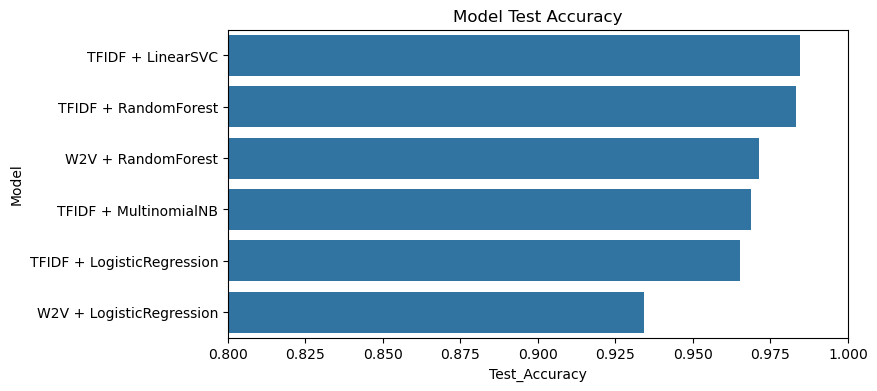

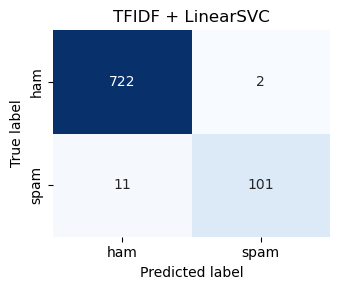

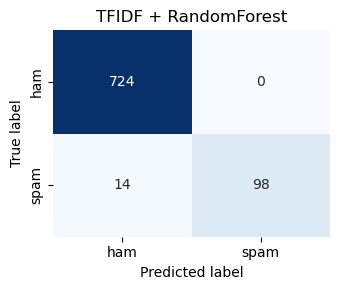

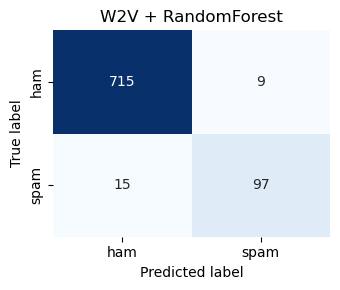

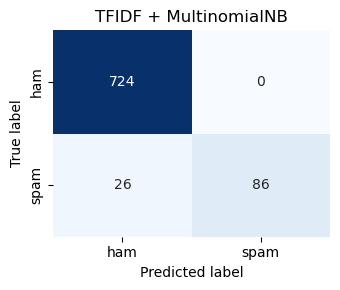

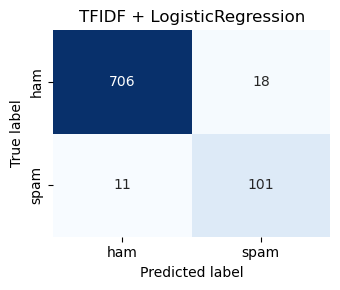

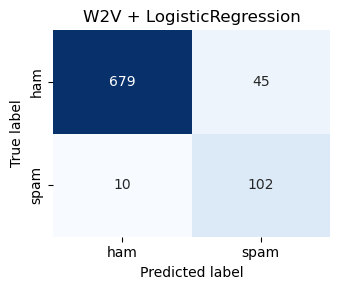

In [19]:
# Plot accuracies
plt.figure(figsize=(8,4))
sns.barplot(data=res_df, x="Test_Accuracy", y="Model")
plt.xlim(0.8, 1.0)
plt.title("Model Test Accuracy")
plt.show()

# Plot confusion matrices
import itertools
def plot_cm(cm, classes=('ham','spam'), title="Confusion matrix"):
    plt.figure(figsize=(3.5,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label'); plt.xlabel('Predicted label'); plt.title(title)
    plt.tight_layout(); plt.show()

for _, row in res_df.iterrows():
    plot_cm(row['Confusion_Matrix'], title=row['Model'])


In [20]:
# ==============================
# 💾 7. Save preprocessing helpers for Streamlit app
# ==============================
# We'll save the clean_text tokenizer behavior alongside TF-IDF and W2V assets.
import json, inspect

# Save a small config to keep W2V dim, etc.
config = {"w2v_dim": w2v_dim}
json.dump(config, open("artifacts/config.json","w"))

# Save stopwords for the app (optional — they’re standard but we keep it consistent)
with open("artifacts/stopwords.txt","w") as f:
    f.write("\n".join(sorted(list(stop_words))))

print("Saved artifacts:", os.listdir("artifacts"))


Saved artifacts: ['config.json', 'stopwords.txt', 'tfidf_logreg.joblib', 'tfidf_nb.joblib', 'tfidf_vectorizer.joblib', 'w2v_logreg.joblib', 'w2v_rf.joblib', 'word2vec.model']
